# بسم الله الرحمن الرحيم

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import tensorflow as tf
import zipfile

# load data

In [4]:
with zipfile.ZipFile('https://drive.google.com/file/d/1KCKfyIGbQi8a7bIYta3LM8dFStxVzVX-/view?usp=sharing','r') as file :
  file.extractall('/content/Data set')

Zip file downloaded and extracted to: /tmp/.keras/datasets/Shop_DataSet_extracted


/tmp/ipython-input-2139861239.py:4: UserWarning: Could not extract archive.
  zip_path = tf.keras.utils.get_file(


In [ ]:
dataset = {}
datapath = '/content/Data set/Shop DataSet'

for filename in os.listdir(datapath):
  videos_paths = []
  for video_name in os.listdir(os.path.join(datapath,filename)):
    videos_paths.append(os.path.join(datapath,filename,video_name))
  dataset[filename] = videos_paths


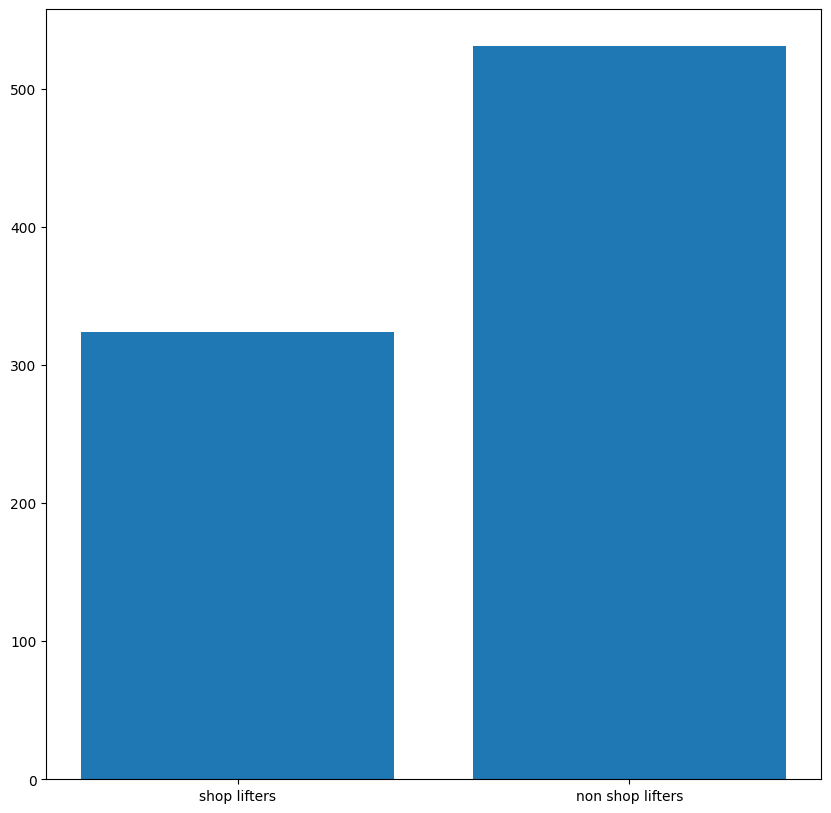

In [ ]:
plt.figure(figsize=(10,10))
plt.bar(dataset.keys(), [len(videos) for videos in dataset.values()])
plt.show()

In [ ]:
data_list = []
for category, videos in dataset.items():
    for video_path in videos:
        data_list.append({'labels': category, 'Video Path': video_path})

df_videos = pd.DataFrame(data_list)
df_videos

,labels,Video Path
0,shop lifters,/content/Data set/Shop DataSet/shop lifters/sh...
1,shop lifters,/content/Data set/Shop DataSet/shop lifters/sh...
2,shop lifters,/content/Data set/Shop DataSet/shop lifters/vi...
3,shop lifters,/content/Data set/Shop DataSet/shop lifters/sh...
4,shop lifters,/content/Data set/Shop DataSet/shop lifters/sh...
...,...,...
850,non shop lifters,/content/Data set/Shop DataSet/non shop lifter...
851,non shop lifters,/content/Data set/Shop DataSet/non shop lifter...
852,non shop lifters,/content/Data set/Shop DataSet/non shop lifter...
853,non shop lifters,/content/Data set/Shop DataSet/non shop lifter...


Minority class: shop lifters with 324 samples
Majority class: non shop lifters with 531 samples

Class distribution after oversampling:
labels
non shop lifters    531
shop lifters        531
Name: count, dtype: int64


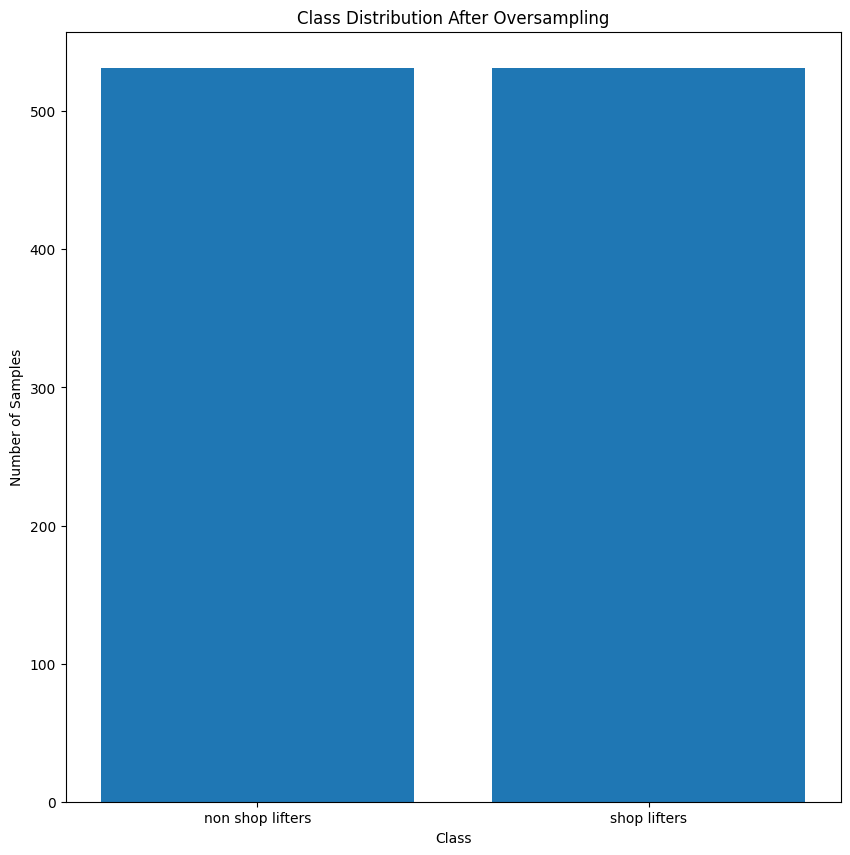

In [ ]:
# Identify the minority and majority classes
class_counts = df_videos['labels'].value_counts()
minority_class = class_counts.idxmin()
majority_class = class_counts.idxmax()
minority_count = class_counts[minority_class]
majority_count = class_counts[majority_class]

print(f"Minority class: {minority_class} with {minority_count} samples")
print(f"Majority class: {majority_class} with {majority_count} samples")

# Separate minority and majority class samples
df_minority = df_videos[df_videos['labels'] == minority_class]
df_majority = df_videos[df_videos['labels'] == majority_class]

# Randomly duplicate minority class samples
df_minority_oversampled = df_minority.sample(majority_count, replace=True, random_state=42)

# Concatenate the oversampled minority class with the majority class
df_oversampled = pd.concat([df_majority, df_minority_oversampled], axis=0)

# Shuffle the oversampled dataset
df_oversampled = df_oversampled.sample(frac=1, random_state=42).reset_index(drop=True)

print("\nClass distribution after oversampling:")
print(df_oversampled['labels'].value_counts())

oversampled_class_counts = df_oversampled['labels'].value_counts()
plt.figure(figsize=(10,10))
plt.bar(oversampled_class_counts.index, oversampled_class_counts.values)
plt.title('Class Distribution After Oversampling')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.show()

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_oversampled['labels'] = le.fit_transform(df_oversampled['labels'])
df_oversampled

,labels,Video Path
0,0,/content/Data set/Shop DataSet/non shop lifter...
1,0,/content/Data set/Shop DataSet/non shop lifter...
2,1,/content/Data set/Shop DataSet/shop lifters/vi...
3,1,/content/Data set/Shop DataSet/shop lifters/sh...
4,1,/content/Data set/Shop DataSet/shop lifters/sh...
...,...,...
1057,0,/content/Data set/Shop DataSet/non shop lifter...
1058,0,/content/Data set/Shop DataSet/non shop lifter...
1059,0,/content/Data set/Shop DataSet/non shop lifter...
1060,1,/content/Data set/Shop DataSet/shop lifters/vi...


In [ ]:

def video_generator(df, frames_per_video=32, img_size=(224,224)):
    for _, row in df.iterrows():
        path = row['Video Path']
        label = row['labels']
        cap = cv2.VideoCapture(path)
        frames = []
        while len(frames) < frames_per_video:
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.resize(frame, img_size)
            frame = frame[:, :, ::-1]            # BGR -> RGB
            frame = frame.astype(np.float32) / 255.0
            frames.append(frame)
        cap.release()
        # padding if short
        while len(frames) < frames_per_video:
            frames.append(np.zeros_like(frames[0], dtype=np.float32))
        yield np.array(frames, dtype=np.float32), np.int32(label)

# output signature (channels_last): (frames, H, W, C)
frames_per_video = 16
img_size = (256, 256)
output_signature = (
    tf.TensorSpec(shape=(frames_per_video, img_size[0], img_size[1], 3), dtype=tf.float32),
    tf.TensorSpec(shape=(), dtype=tf.int32)
)

In [ ]:
# split data into train, validation , and test
from sklearn.model_selection import train_test_split

# Split the oversampled DataFrame
train_df, test_df = train_test_split(df_oversampled, test_size=0.2, random_state=42)

# Create TensorFlow Datasets from the split DataFrames
train_ds = tf.data.Dataset.from_generator(
    lambda: video_generator(train_df, frames_per_video, img_size),
    output_signature=output_signature
)

test_ds = tf.data.Dataset.from_generator(
    lambda: video_generator(test_df, frames_per_video, img_size),
    output_signature=output_signature
)


# optional augmentation function (tf ops)
def augment(frames, label):
    # frames: (T,H,W,C)
    frames = tf.image.random_flip_left_right(frames)
    # you can add random crop, brightness, etc.
    return frames, label

# Apply augmentation to the training dataset
train_ds = train_ds.shuffle(200).map(augment, num_parallel_calls=tf.data.AUTOTUNE)

# Batch and prefetch both datasets
train_ds = train_ds.batch(4).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(4).prefetch(tf.data.AUTOTUNE)

print("Training dataset:")
print(train_ds)
print("\nTesting dataset:")
print(test_ds)

Training dataset:
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 16, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

Testing dataset:
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 16, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [ ]:
# CNN - LSTM model
def build_cnn_lstm_model(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)    # (D, H, W, C)

    # Step 1: TimeDistributed CNN to extract frame-level features
    cnn_base = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Batch
        tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Flatten()
    ])

    x = tf.keras.layers.TimeDistributed(cnn_base)(inputs)   # (D, feature_dim)

    # Step 2: LSTM to process temporal sequence
    x = tf.keras.layers.LSTM(128, return_sequences=False)(x)  # output: (hidden_dim)

    # Step 3: Fully connected layers for classification
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs, outputs)
    return model


In [ ]:
model = build_cnn_lstm_model(
    input_shape=(frames_per_video , img_size[0], img_size[1], 3)
)

In [ ]:
# train model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    epochs = 15 ,
    validation_data = test_ds
)

Epoch 1/15
    213/Unknown 226s 855ms/step - accuracy: 0.5010 - loss: 1.0741

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


213/213 ━━━━━━━━━━━━━━━━━━━━ 257s 1s/step - accuracy: 0.5012 - loss: 1.0732 - val_accuracy: 0.5023 - val_loss: 5.2567
Epoch 2/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 197s 871ms/step - accuracy: 0.5862 - loss: 0.7880 - val_accuracy: 0.5023 - val_loss: 4.7225
Epoch 3/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 202s 873ms/step - accuracy: 0.5901 - loss: 0.7066 - val_accuracy: 0.5023 - val_loss: 3.6109
Epoch 4/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 204s 884ms/step - accuracy: 0.5891 - loss: 0.7599 - val_accuracy: 0.5023 - val_loss: 3.3361
Epoch 5/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 196s 874ms/step - accuracy: 0.6180 - loss: 0.6871 - val_accuracy: 0.5023 - val_loss: 1.6167
Epoch 6/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 203s 874ms/step - accuracy: 0.6340 - loss: 0.6780 - val_accuracy: 0.5023 - val_loss: 10.1432
Epoch 7/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 198s 877ms/step - accuracy: 0.6894 - loss: 0.6075 - val_accuracy: 0.5023 - val_loss: 2.1460
Epoch 8/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 203s 879ms/step - accuracy: 0.7310 - loss: 0.5605

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
loss , acc = model.evaluate(test_ds)

In [ ]:
print(f"Loss : {loss}")
print(f"Accuracy : {acc}")